<a href="https://colab.research.google.com/github/DJCordhose/mlops-drift/blob/main/notebooks/drift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting drift

* you can let evidently choose the test or make your own choice
  * allows to select per type or per feature: https://docs.evidentlyai.com/reference/api-reference/evidently.options
  * which test: https://www.evidentlyai.com/blog/data-drift-detection-large-datasets
* Drift algorithm: https://docs.evidentlyai.com/reference/data-drift-algorithm  

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 16

In [3]:
import seaborn as sns
sns.__version__

'0.13.0'

In [4]:
if IN_COLAB:
  !pip install -q evidently==0.4.8

In [5]:
import evidently
evidently.__version__

'0.4.8'

In [6]:
from evidently.metrics import DatasetDriftMetric
from evidently.base_metric import InputData, ColumnMapping
from evidently.runner.loader import DataLoader, DataOptions
from evidently.calculations.data_drift import get_drift_for_columns
from evidently.options.data_drift import DataDriftOptions
from evidently.utils.data_operations import process_columns

## Preparing reference and current dataset

In [7]:
def url_for_dataset(relative_path):
  if IN_COLAB:
    url = f'https://github.com/DJCordhose/buch-machine-learning-notebooks/raw/main/kap11/datasets/insurance_prediction/{relative_path}.csv.gz'
  else:
    url =  f'./datasets/insurance_prediction/{relative_path}.csv.gz'
  return url

In [8]:
# how many months after training?
iteration = 36 # final month in dataset, should have the biggest difference
# iteration = 12 # one year later, drift should starting to show

In [9]:
reference_dataset_url = url_for_dataset(f'reference')
current_dataset_url = url_for_dataset(f'monthly/month-{iteration}')

In [10]:
# could just as well be pandas code
reference_dataset = DataLoader().load(
   filename=reference_dataset_url,
   data_options = DataOptions(date_column=None, separator=';'),
)
reference_dataset = reference_dataset.drop(['risk', 'group', 'group_name', 'good_customer'], axis='columns')
reference_dataset.head()

,training,age,emergency_braking,braking_distance,power,milage
0,0,41.951100,0,40.933328,122.238329,98.509765
1,0,24.368286,1,44.797317,113.765298,46.324178
2,0,18.314649,1,41.587241,143.427269,76.862968
3,0,51.265254,1,47.266716,111.578133,102.697069
4,0,23.578861,0,42.835319,145.994235,63.690055


In [11]:
# could just as well be pandas code
current_dataset = DataLoader().load(
   filename=current_dataset_url,
   data_options = DataOptions(date_column=None, separator=';'),
)
current_dataset = current_dataset.drop(['risk', 'group', 'group_name', 'good_customer'], axis='columns')
current_dataset.head()

,training,age,emergency_braking,braking_distance,power,milage
0,0,45.700860,1,33.730669,118.306787,92.429050
1,0,53.091268,1,35.575746,168.151487,53.595707
2,1,41.989477,1,37.515860,104.683894,40.402020
3,0,41.792728,1,44.043184,143.531543,46.462029
4,1,28.679302,1,34.329172,85.439495,39.791829


## Target / Prediction

In [12]:
binary_classifications = True

In [13]:
import tensorflow as tf
tf.__version__

2023-11-03 11:30:21.358978: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-03 11:30:21.368526: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-03 11:30:21.450317: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-03 11:30:21.450389: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-03 11:30:21.450421: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

'2.14.0'

In [14]:
if IN_COLAB:
  !wget https://github.com/DJCordhose/buch-machine-learning-notebooks/raw/main/kap11/classifier-binary.keras
model_path = 'classifier'
model = tf.keras.models.load_model(f'{model_path}-binary.keras')

In [15]:
def prediction_name(value: int):
  if binary_classifications:
    names = ['BAD', 'GOOD']
  else:
    names = ['HIGH', 'MEDIUM', 'LOW']
  return names[value]

def predict(X):
  if not binary_classifications:
      y_pred = model.predict(X).argmax(axis=1)
  else:
      threshold = .5
      y_pred = (model.predict(X) > threshold).ravel().astype("int")
  return list(map(prediction_name, y_pred))


In [16]:
X = current_dataset
current_dataset_prediction = X.copy()
current_dataset_prediction['prediction'] = predict(X)
current_dataset_prediction.head()

47/47 [==============================] - 0s 3ms/step


,training,age,emergency_braking,braking_distance,power,milage,prediction
0,0,45.700860,1,33.730669,118.306787,92.429050,GOOD
1,0,53.091268,1,35.575746,168.151487,53.595707,BAD
2,1,41.989477,1,37.515860,104.683894,40.402020,GOOD
3,0,41.792728,1,44.043184,143.531543,46.462029,GOOD
4,1,28.679302,1,34.329172,85.439495,39.791829,GOOD


In [17]:
X = reference_dataset
y_pred = model.predict(X, verbose=0).argmax(axis=1)
reference_dataset_prediction = X.copy()
reference_dataset_prediction['prediction'] =  predict(X)
reference_dataset_prediction.head()

47/47 [==============================] - 0s 3ms/step


,training,age,emergency_braking,braking_distance,power,milage,prediction
0,0,41.951100,0,40.933328,122.238329,98.509765,BAD
1,0,24.368286,1,44.797317,113.765298,46.324178,BAD
2,0,18.314649,1,41.587241,143.427269,76.862968,BAD
3,0,51.265254,1,47.266716,111.578133,102.697069,BAD
4,0,23.578861,0,42.835319,145.994235,63.690055,BAD


# Calculating Drift

In [18]:
column_mapping = ColumnMapping(
    categorical_features=['training', 'emergency_braking'],
    numerical_features=['age', 'braking_distance', 'power', 'milage'],
    prediction="prediction",
    target=None,
)
drift_share = 0.5
columns = column_mapping.categorical_features + column_mapping.numerical_features + [column_mapping.prediction]
columns

['training',
 'emergency_braking',
 'age',
 'braking_distance',
 'power',
 'milage',
 'prediction']

In [19]:
input_data = InputData(
    reference_data=reference_dataset_prediction,
    current_data=current_dataset_prediction,
    column_mapping=column_mapping,
    current_additional_features=None,
    data_definition=None,
    reference_additional_features=None,
    additional_datasets=None
)

In [20]:
dataset_columns = process_columns(input_data.reference_data, input_data.column_mapping)
dataset_columns

DatasetColumns(type='evidently.metric_results.DatasetColumns', utility_columns=DatasetUtilityColumns(type='evidently.metric_results.DatasetUtilityColumns', date=None, id=None, target=None, prediction='prediction'), target_type='cat', num_feature_names=['age', 'braking_distance', 'milage', 'power'], cat_feature_names=['training', 'emergency_braking'], text_feature_names=[], datetime_feature_names=[], target_names=None, task=None)

In [21]:
result = get_drift_for_columns(
    current_data=input_data.current_data,
    reference_data=input_data.reference_data,
    data_drift_options=DataDriftOptions(),
    drift_share_threshold=drift_share,
    dataset_columns=dataset_columns,
    columns=columns,
    agg_data = True
)

In [22]:
result.number_of_columns

7

In [23]:
result.number_of_drifted_columns

4

In [24]:
result.share_of_drifted_columns

0.5714285714285714

In [25]:
result.dataset_drift

True

## You can breakt it down to the level of each test

* can be helpful to have your own weights
* e.g. weigh to feature importance or heighest correlation to target
  * corrlation will probably change over time, make sure to adjust when training new model
  * have a look at correlation plot below 
* or feature known to be most brittle
* or feature most important to domain / business

In [26]:
for column in columns:
    drift = result.drift_by_columns[column]
    print(f'{column}: {drift.drift_score} ({drift.stattest_name}){", drifted" if drift.drift_detected else ""}')

training: 0.026168996995345487 (Jensen-Shannon distance)
emergency_braking: 0.431489050691815 (Jensen-Shannon distance), drifted
age: 0.33634057577174653 (Wasserstein distance (normed)), drifted
braking_distance: 0.07052872681963733 (Wasserstein distance (normed))
power: 0.027969027840461617 (Wasserstein distance (normed))
milage: 0.7140663279609664 (Wasserstein distance (normed)), drifted
prediction: 0.10925847786821055 (Jensen-Shannon distance), drifted


In [27]:
features = ['training', 'age', 'emergency_braking', 'braking_distance', 'power', 'miles', 'risk']

def plot_correlation(df, ax, title):
    df_corr = df.drop(columns=["group", "group_name", "good_customer"])

    cm = df_corr.corr()

    hm = sns.heatmap(cm,
                     ax=ax,
                    cbar=True,
                    annot=True,
                    square=True,
                    cmap='RdBu',
                    center=0,
                    fmt='.2f',
                    yticklabels=features,
                    xticklabels=features)

    ax.set_title(title, y=1.02, fontsize=18);

In [28]:
import pandas as pd

df_reference = pd.read_csv(url_for_dataset(f'reference'), delimiter=';')
df_iteration = pd.read_csv(url_for_dataset(f'monthly/month-{iteration}'), delimiter=';')

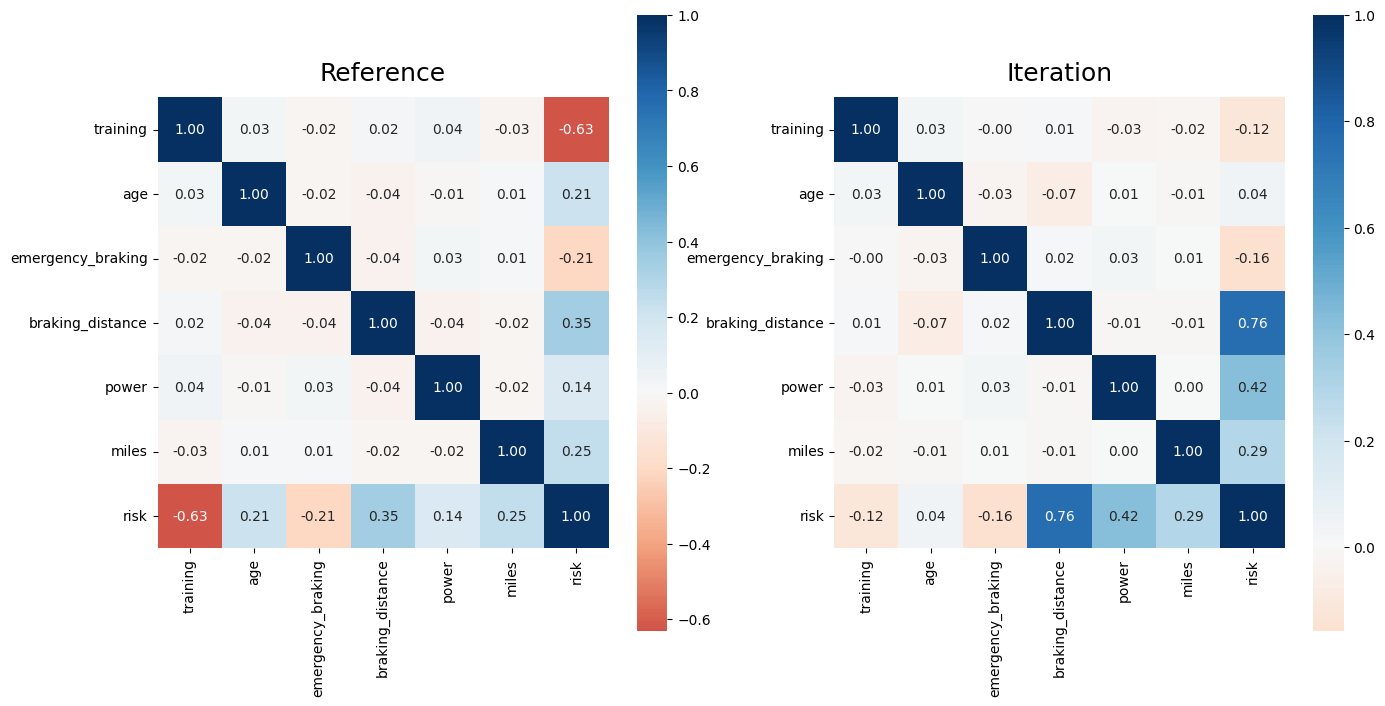

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))


plot_correlation(df_reference, ax1, "Reference")
plot_correlation(df_iteration, ax2, "Iteration")
# plt.tight_layout()


# Comparing different stats tests

https://www.evidentlyai.com/blog/data-drift-detection-large-datasets

In [30]:
from evidently.calculations.stattests.jensenshannon import jensenshannon_stat_test
from evidently.calculations.stattests.kl_div import kl_div_stat_test
from evidently.calculations.stattests.ks_stattest import ks_stat_test
from evidently.calculations.stattests.psi import psi_stat_test
from evidently.calculations.stattests.wasserstein_distance_norm import wasserstein_stat_test

In [31]:
current_dataset_prediction.head()

,training,age,emergency_braking,braking_distance,power,milage,prediction
0,0,45.700860,1,33.730669,118.306787,92.429050,GOOD
1,0,53.091268,1,35.575746,168.151487,53.595707,BAD
2,1,41.989477,1,37.515860,104.683894,40.402020,GOOD
3,0,41.792728,1,44.043184,143.531543,46.462029,GOOD
4,1,28.679302,1,34.329172,85.439495,39.791829,GOOD


In [32]:
reference_dataset_prediction.head()

,training,age,emergency_braking,braking_distance,power,milage,prediction
0,0,41.951100,0,40.933328,122.238329,98.509765,BAD
1,0,24.368286,1,44.797317,113.765298,46.324178,BAD
2,0,18.314649,1,41.587241,143.427269,76.862968,BAD
3,0,51.265254,1,47.266716,111.578133,102.697069,BAD
4,0,23.578861,0,42.835319,145.994235,63.690055,BAD


In [33]:
feature_name = "age"
reference_feature = reference_dataset_prediction[feature_name]
current_feature = current_dataset_prediction[feature_name]

In [34]:
wasserstein_stat_test(reference_feature, current_feature, 'num', threshold=None)

StatTestResult(drift_score=0.33634057577174653, drifted=True, actual_threshold=0.1)

In [35]:
ks_stat_test(reference_feature, current_feature, 'num', threshold=None)

StatTestResult(drift_score=1.774673024118679e-13, drifted=True, actual_threshold=0.05)

In [36]:
psi_stat_test(reference_feature, current_feature, 'num', threshold=None)

StatTestResult(drift_score=3.2251039743059975, drifted=True, actual_threshold=0.1)

In [37]:
feature_name = "emergency_braking"
reference_feature = reference_dataset_prediction[feature_name]
current_feature = current_dataset_prediction[feature_name]

In [38]:
jensenshannon_stat_test(reference_feature, current_feature, 'cat', threshold=None)

StatTestResult(drift_score=0.431489050691815, drifted=True, actual_threshold=0.1)

In [39]:
psi_stat_test(reference_feature, current_feature, 'cat', threshold=None)

StatTestResult(drift_score=1.720420101181165, drifted=True, actual_threshold=0.1)

In [40]:
kl_div_stat_test(reference_feature, current_feature, 'cat', threshold=None)

StatTestResult(drift_score=1.0460420987709491, drifted=True, actual_threshold=0.1)